## Volatility estimation

### Price adjustment

We begin by importing the volatility module, which contains functions to calculate volatility estimates, including the Yang-Zhang drift-independent estimator.

In [1]:
# standard packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# set max number of rows for display
pd.set_option('max_rows', 9)

# import my volatility package
import volatility as v

In [2]:
# set default size of figures
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]

In [3]:
# from importlib import reload

In [4]:
# # switch to inline
# %matplotlib inline
# reload(plt)
# plt.rcParams['figure.figsize'] = [12, 8]

In [5]:
# # switch to notebook
# %matplotlib notebook
# reload(plt)
# plt.rcParams['figure.figsize'] = [12, 8]

We will use data for Microsoft (NASDAQ: MSFT), downloaded from Yahoo Finance: https://finance.yahoo.com/quote/MSFT/

The file MSFT.csv contains a history of prices starting on 13 March 1986 (the day Microsoft went public). We import this file into a Pandas DataFrame.

In [6]:
data = pd.read_csv('./data/MSFT.csv', index_col='Date', parse_dates=True)
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1986-03-13,0.088542,0.101563,0.088542,0.097222,0.070555,1031788800
1986-03-14,0.097222,0.102431,0.097222,0.100694,0.073075,308160000
1986-03-17,0.100694,0.103299,0.100694,0.102431,0.074335,133171200
1986-03-18,0.102431,0.103299,0.098958,0.099826,0.072445,67766400
1986-03-19,0.099826,0.100694,0.097222,0.098090,0.071185,47894400


We plot the adjusted close price over time. If you are running this notebook in a live environment, try selecting the cell below by clicking on it, then typing 'l' (small 'L') when the mouse is over an axis, to convert the y axis to log scale.

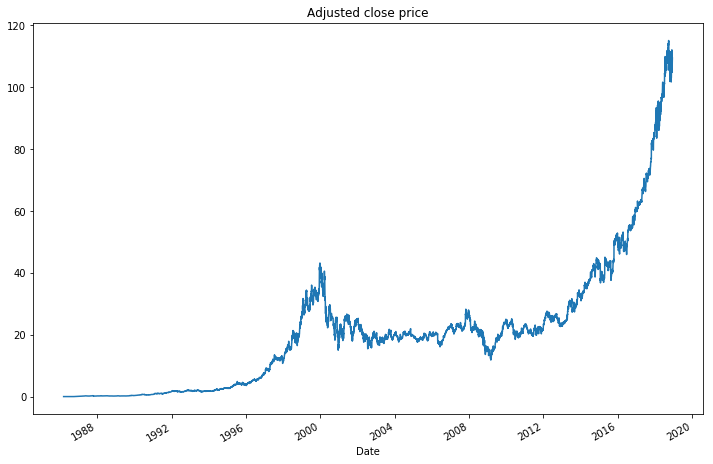

In [7]:
data['Adj Close'].plot(title='Adjusted close price');

All the columns in the Yahoo finance data are adjusted for stock splits. However, only the 'Adj Close' column is adjusted for dividends, using the following methodology.

Starting at the most recent date and going backwards in time, the adjusted and unadjusted close prices are equal until we reach the first (most recent) ex-dividend date $t_1$. The adjusted close price between $t_1$ and the next ex-date $t_2$ is equal to the close price multiplied by $\left( 1 - {D_{t_1}}/{C_{t_1^-}} \right)$, where $D_{t_1}$ is the amount of the dividend, and $C_{t_1^-}$ is the close price on the day prior to the ex-date.

Therefore, the adjustment ratio $A_t/C_t$ is given by the following expression, where $A_t$ is the adjusted close price at time $t$:

$$\frac{A_t}{C_t} = \prod_{i\ :\ t_i \gt t} \left( 1 - \frac{D_{t_i}}{C_{t_i^-}} \right)$$

We extract this ratio from our data, and examine when it changes:

In [8]:
adj_ratio = data['Adj Close']/data['Close']
dividend_dates = data.index[adj_ratio.abs().diff() > 1e-4]

data['Adj Ratio'] = adj_ratio
data.loc[dividend_dates, ['Close', 'Adj Close', 'Adj Ratio']]

,Close,Adj Close,Adj Ratio
Date,,,
2003-02-19,24.530001,17.858856,0.728041
2003-10-15,29.070000,21.282906,0.732126
2004-08-23,27.240000,20.001944,0.734286
2004-11-15,27.389999,20.165922,0.736251
...,...,...,...
2018-02-14,90.809998,89.684029,0.987601
2018-05-16,97.150002,96.361282,0.991881
2018-08-15,107.660004,107.196907,0.995699
2018-11-14,104.970001,104.970001,1.000000


As expected, these are all dividend dates (MSFT started paying dividends in 2003).

We now adjust the open, high, low, and close using the adjustment ratio:

In [9]:
ohlc = data[['Open', 'High', 'Low', 'Close']].mul(adj_ratio, axis=0)
ohlc.loc[dividend_dates]

,Open,High,Low,Close
Date,,,,
2003-02-19,18.069987,18.113669,17.596760,17.858856
2003-10-15,21.378083,21.422010,21.012020,21.282906
2004-08-23,20.023973,20.068030,19.913830,20.001944
2004-11-15,20.129110,20.246910,20.026036,20.165922
...,...,...,...,...
2018-02-14,87.412551,89.861797,87.313793,89.684029
2018-05-16,96.569576,96.609252,95.835586,96.361282
2018-08-15,108.023331,108.521180,106.360516,107.196907
2018-11-14,108.099998,108.260002,104.470001,104.970001


### Comparison of volatility estimates

We begin by calculating the simple close-to-close log returns and plotting them.

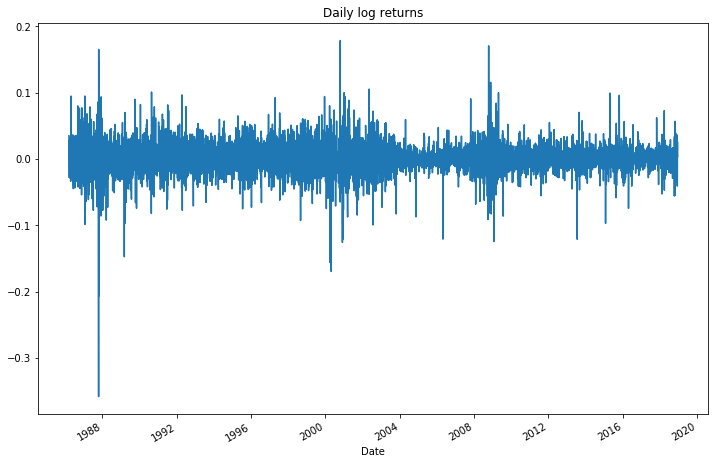

In [10]:
logreturns = v.log_returns(ohlc['Close'])
logreturns.plot(title='Daily log returns');

As one can see from the chart of log returns, the volatility of the stock varies over time. To see this even more clearly, we calculate the annualized close-to-close volatility of the stock for each calendar year and plot the results below.

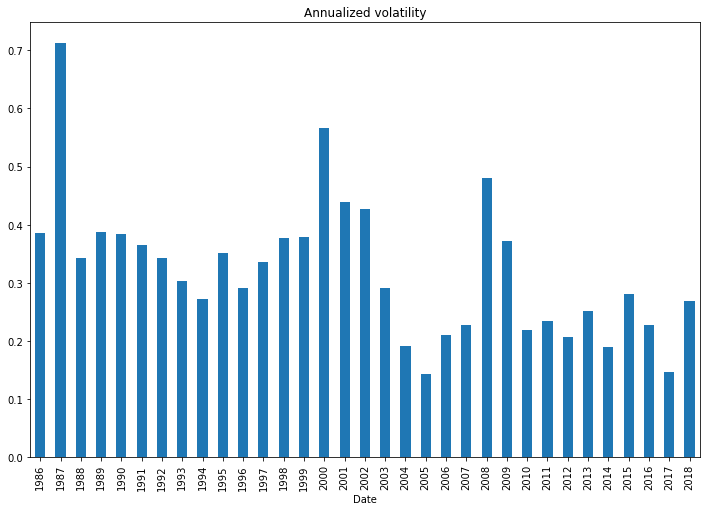

In [11]:
vol = logreturns.groupby(logreturns.index.year).std()
vol = v.annualize_vol(vol)
vol.plot.bar(title='Annualized volatility', color='C0');

In [12]:
# from importlib import reload
# reload(v)

In [13]:
from ipywidgets import interact
import ipywidgets as widgets

In [14]:
# calculate returns as defined in Yang-Zhang ("normalized prices")
yzr = v.yzreturns(ohlc)

vwindow = widgets.IntSlider(value=100, min=5, max=252, continuous_update=False)
years = widgets.IntRangeSlider(min=1986, max=2018, continuous_update=False)

@interact(w=vwindow, y=years)
def f(w, y):

    # window for vol calc
    vwindow = w
    start = str(y[0])
    end = str(y[1])

    # set up new DataFrame
    vol = pd.DataFrame()

    # simple volatility
    vol['Simple'] = v.simple_vol_rolling(logreturns, vwindow)

    # Rogers-Satchell volatility
    vol['RS'] = v.rsvol_rolling(yzr, vwindow)

    # Yang-Zhang volatility
    vol['YZ'] = v.yzvol_rolling(yzr, vwindow)

    vol.loc[start:end].plot();

interactive(children=(IntSlider(value=100, continuous_update=False, description='w', max=252, min=5), IntRange…